In [1]:
import re
import numpy as np
from wrapper_my_radex import myradex_wrapper as wrapper 
phy_c_cgs=299792458e2
phy_c_SI=299792458
phy_k_cgs=1.3806503e-16
phy_h_cgs=6.62606896e-27
phy_cm2erg=phy_h_cgs*phy_c_cgs
phy_cm2K=phy_cm2erg/phy_k_cgs
class colli_partner:
    def __init__(self,part_name):
        self.name=part_name
    def set_n_trans(self,n_trans):
        self.n_transitions=n_trans
    def set_n_T(self,n_T):
        self.n_T=n_T
    def set_colli_temp(self,col_temp):
        self.colli_temperature=col_temp
    def set_Cul(self,Cul):
        self.Cul=Cul
class mol_data:
    def __init__(self,mol_dir,mol_file):
        self.mol_dir=mol_dir
        self.mol_file=mol_file
        f=open(self.mol_dir+self.mol_file)
        file_list=re.split('\n',f.read())
        f.close()
        if_read=True
        self.mol_name=re.split(' ',file_list[1])
        self.n_level=int(file_list[5])
        self.level_energy=np.zeros(self.n_level)
        self.level_weight=np.zeros(self.n_level)
        nrow=7
        for i in range(self.n_level):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            self.level_energy[i]=float(line[1])*phy_cm2K
            self.level_weight[i]=float(line[2])
        nrow+=self.n_level+1
        self.n_transitions=int(file_list[nrow])
        nrow+=2
        self.rad_data=np.zeros([self.n_transitions,9]) # iup, ilow, Aul, freq, lambda, Eup, Elow, Bul, Blu
        for i in range(self.n_transitions):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            iu=int(line[1])
            il=int(line[2])
            self.rad_data[i,0]=iu
            self.rad_data[i,1]=il
            self.rad_data[i,2]=float(line[3])
            self.rad_data[i,3]=phy_c_cgs*(self.level_energy[iu-1]-self.level_energy[il-1])/phy_cm2K
            self.rad_data[i,4]=phy_c_SI/self.rad_data[i,3]*1e6  # micron
            self.rad_data[i,5]=self.level_energy[iu-1]
            self.rad_data[i,6]=self.level_energy[il-1]
            self.rad_data[i,7]=self.rad_data[i,2]/((2*phy_h_cgs/phy_c_cgs**2)*self.rad_data[i,3]**3)
            self.rad_data[i,8]=self.rad_data[i,7]*self.level_weight[iu-1]/self.level_weight[il-1]
        nrow+=self.n_transitions+1
        self.n_partner=int(file_list[nrow])
        nrow+=2
        self.colli_data={}
        for i in range(self.n_partner):
            line=re.split(' |-|\t|\+|:',file_list[nrow])
            line=[item for item in line if item!='']
            part_name=line[2]
            if part_name=='electron':
                part_name='e'
            elif part_name=='with':
                part_name=line[3]
            partner=colli_partner(part_name)
            partner.set_n_trans(int(file_list[nrow+2]))
            partner.set_n_T(int(file_list[nrow+4]))
            line=re.split(' |\t',file_list[nrow+6])
            line=np.array([item for item in line if item!=''])
            partner.set_colli_temp(line.astype(float))
            Cul=np.zeros([partner.n_transitions,partner.n_T+2])
            for j in range(partner.n_transitions):
                line=re.split(' |\t',file_list[nrow+8+j])
                line=np.array([item for item in line if item!=''])
                Cul[j]=line[1:].astype(float)
            partner.set_Cul(Cul.T)
            self.colli_data[part_name]=partner
            nrow+=9+partner.n_transitions
        self.data_shape=[self.n_level,self.n_transitions,self.n_partner]
        self.partner_names=list(self.colli_data.keys())
        self.colli_shape=[[self.colli_data[key].n_transitions,self.colli_data[key].n_T] for key in self.colli_data.keys()]
        self.level_data=np.concatenate([[self.level_energy],[self.level_weight]],axis=0).T
        colli_T=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])])
        colli_Cul=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])+2,max([self.colli_data[key].n_transitions for key in self.partner_names])])
        for i in range(self.n_partner):
            partner_name=self.partner_names[i]
            colli_T[i,:self.colli_data[partner_name].n_T]=self.colli_data[partner_name].colli_temperature
            colli_Cul[i,:self.colli_data[partner_name].n_T+2,:self.colli_data[partner_name].n_transitions]=self.colli_data[partner_name].Cul
        self.colli_T=colli_T
        self.colli_Cul=colli_Cul
        space=' '
        self.part_name_str=space.join(self.partner_names)

def compute_Ncol(nH2,abundance_Kvir):    
    Ncol=3.08e18*nH2*abundance_Kvir*1/(0.65*1.5**0.5*(nH2/1e3)**0.5)  #Papadopoulos et al. (2012)  Tunnard et al. (2015)
    return Ncol
def Tbtoflux(Tb,freq,solid_angle):              #K, Hz, arcsec^2
    I_nu=2*phy_k_cgs*Tb*freq**2/(phy_c_cgs)**2          #Essensial Radio Astronomy P35
    flux=I_nu*solid_angle/(180/np.pi*3600)**2 *1e23                 #Jy  #Essensial Radio Astronomy P50
    return flux
def compute_gasmass(NH2col,solid_angle,ang2phy):
    area=solid_angle*ang_phy**2  #kpc^2
    gasmass=N_H2_col*(2*1.66053904e-24)*area*(1e3*3.08567758e18)**2/1.98855e33 #solar mass
    return gasmass
def find_best_scale(params,scale_range1,scale_range2):
    p=-np.inf
    a,b,c,d=scale_range1[0],scale_range1[1],scale_range2[0],scale_range2[1]
    params_t1=params*1
    params_t2=params*1
    sol_1s=np.arange(a,b+0.5,0.5)
    sol_2s=np.arange(c,d+0.5,0.5)
    for sol_1 in sol_1s:
        for sol_2 in sol_2s:
            params_t1[5]=sol_1
            params_t1[9]=sol_2
            p_t=log_likelyhood(params_t1)
            if p<p_t:
                p=p_t*1
                params_m=params_t1*1
    a,b,c,d=params_m[5]-1,params_m[5]+1,params_m[9]-1,params_m[9]+1
    while(abs(b-a)>0.0001 and abs(c-d)>0.0001):
        m=(a+b)/2
        n=(c+d)/2
        params_t1[5]=(a+m)/2
        params_t1[9]=n
        params_t2[5]=(m+b)/2
        params_t2[9]=n
        if log_likelyhood(params_t1)>log_likelyhood(params_t2):
            b=m
        else:
            a=m
        params_t1[5]=m
        params_t1[9]=(c+n)/2
        params_t2[5]=m
        params_t2[9]=(n+d)/2
        if log_likelyhood(params_t1)>log_likelyhood(params_t2):
            d=n
        else:
            c=n
    params_t1[5]=(a+b)/2
    params_t1[9]=(c+d)/2
    print('maximum possibility parameter is ',params_t1)
    return params_t1
def gradient_descent(params):
    dim=len(params)
    dx=0.01
    iiter=0
    gradient_scale=np.empty(dim)
    while(not (gradient_scale==0).all()):
        for i in range(dim):
            params_t=params*1
            p0=log_likelyhood(params_t)
            params_t[i]-=dx
            p1=log_likelyhood(params_t)
            params_t[i]+=2*dx
            p2=log_likelyhood(params_t)
            if p1>p0>p2:
                gradient_scale[i]=-1
            elif p1<p0<p2:
                gradient_scale[i]=1
            else:
                gradient_scale[i]=0
        params=params+gradient_scale*1/(iiter+3)
        iiter+=1
        print('iter:',iiter,p0,end="\r")
    return params
    
def run_myradex(Tkin,nH2,NXcol,Tbg,molecule,ini_occ=[]):
    if len(ini_occ)==0:
        ini_occ=molecule.level_weight*np.exp(-molecule.level_energy/Tkin)
        ini_occ=ini_occ/sum(ini_occ)
    params = {'tkin': Tkin,
              'ncol_x_cgs': NXcol,
              'h2_density_cgs': nH2,
              'tbg':Tbg,
              'mol_name':molecule.mol_name[0],
              'data_shape':molecule.data_shape,
              'n_transition':molecule.data_shape[1],
              'partner_names':molecule.part_name_str,
              'colli_shape':molecule.colli_shape,
              'level_data':molecule.level_data,
              'rad_data':molecule.rad_data,
              'colli_t':molecule.colli_T,
              'colli_data':molecule.colli_Cul,
              'ini_occ':ini_occ}      #initial occupation
    Tb,f_occupation=wrapper.run_one_params(**params)
    return Tb,f_occupation

In [2]:
source_name='NGC6240'
distance=103.1        #Mpc
ang_phy=np.pi/180/3600*distance*1e6    #pc/arcsec
Tbg=2.73                        #K
velocity_FWHM=360e5   #cm/s
co_Jup=np.arange(13)+1
co_flux=np.array([322,1492,3205,4634,5636,5913,6009,5833,4769,4162,3161,2592,2081])
co_err=np.array([29,253,642,371,149,82,60,89,82,67,74,60,60])
co_err[1:5]=co_err[1:5]/4
hcn_Jup=np.arange(4)+1
hcn_flux=np.array([14,61,74,41])
hcn_err=np.array([2,15,7,6])/4
hco_Jup=np.arange(4)+1
hco_flux=np.array([21,83,141,74])
hco_err=np.array([3,15,21,9])/4
co_mol=mol_data('/home/zj/Documents/radex_mol/','co.dat')
hcn_mol=mol_data('/home/zj/Documents/radex_mol/','hcn.dat')
hco_mol=mol_data('/home/zj/Documents/radex_mol/','hco+@xpol.dat')

In [12]:
class gas_compnent:
    def __init__(self,Tkin,nH2,co_ab_Kv,hcn_ab_Kv,hco_ab_Kv,solidangle):
        self.Tkin,self.nH2,self.co_ab_Kv,self.hcn_ab_Kv,self.hco_ab_Kv,self.solidangle=Tkin,nH2,co_ab_Kv,hcn_ab_Kv,hco_ab_Kv,solidangle
        self.co_Ncol=compute_Ncol(self.nH2,self.co_ab_Kv)
        self.hcn_Ncol=compute_Ncol(self.nH2,self.hcn_ab_Kv)
        self.hco_Ncol=compute_Ncol(self.nH2,self.hco_ab_Kv)
    def compute_Tbs(self):
        self.co_Tb,self.co_occupation=run_myradex(self.Tkin,self.nH2,self.co_Ncol,Tbg,co_mol)
        self.hcn_Tb,self.hcn_occupation=run_myradex(self.Tkin,self.nH2,self.hcn_Ncol,Tbg,hcn_mol)
        self.hco_Tb,self.hco_occupation=run_myradex(self.Tkin,self.nH2,self.hco_Ncol,Tbg,hco_mol)
    def compute_flux(self):
        self.compute_Tbs()
        self.co_flux=Tbtoflux(self.co_Tb,co_mol.rad_data[:,3],self.solidangle)
        self.hcn_flux=Tbtoflux(self.hcn_Tb,hcn_mol.rad_data[:,3],self.solidangle)
        self.hco_flux=Tbtoflux(self.hco_Tb,hco_mol.rad_data[:,3],self.solidangle)
        return self.co_flux,self.hcn_flux,self.hco_flux
def is_physical(params):
    lg_Tkin,lg_nH2,lg_ab_Kvir,lg_solidang=params
    if 1<lg_Tkin<3 and 1<lg_nH2<7 and -10<lg_ab_Kvir<0 and -5<lg_solidang<4:
        return True
    else:
        return False
def log_likelyhood(params):
    if not is_physical(params[2:6]):
        return -np.inf
    if not is_physical(params[6:10]):
        return -np.inf
    if not is_physical(params[10:14]):
        return -np.inf
    ab_hcn_co,ab_hco_co,Tkin_1,nH2_1,co_ab_Kvir_1,solidang_1,Tkin_2,nH2_2,co_ab_Kvir_2,solidang_2,\
            Tkin_3,nH2_3,co_ab_Kvir_3,solidang_3=10**params
    gas_comp1=gas_compnent(Tkin_1,nH2_1,co_ab_Kvir_1,co_ab_Kvir_1*ab_hcn_co,co_ab_Kvir_1*ab_hco_co,solidang_1)
    gas_comp2=gas_compnent(Tkin_2,nH2_2,co_ab_Kvir_2,co_ab_Kvir_2*ab_hcn_co,co_ab_Kvir_2*ab_hco_co,solidang_2)
    gas_comp3=gas_compnent(Tkin_3,nH2_3,co_ab_Kvir_3,co_ab_Kvir_3*ab_hcn_co,co_ab_Kvir_3*ab_hco_co,solidang_3)
    model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
    model_co_flux_2,model_hcn_flux_2,model_hco_flux_2=gas_comp2.compute_flux()
    model_co_flux_3,model_hcn_flux_3,model_hco_flux_3=gas_comp3.compute_flux()
    
    ll_co=-0.5*np.sum(((co_flux-model_co_flux_1[co_Jup-1]-model_co_flux_2[co_Jup-1]-model_co_flux_3[co_Jup-1])/co_err)**2)
    ll_hcn=-0.5*np.sum(((hcn_flux-model_hcn_flux_1[hcn_Jup-1]-model_hcn_flux_2[hcn_Jup-1]-model_hcn_flux_3[hcn_Jup-1])/hcn_err)**2)
    ll_hco=-0.5*np.sum(((hco_flux-model_hco_flux_1[hco_Jup-1]-model_hco_flux_2[hco_Jup-1]-model_hco_flux_3[hco_Jup-1])/hco_err)**2)
    ll_prior=log_prior(params)
    ll_abs=-0.5*(np.sum((co_flux-model_co_flux_1[co_Jup-1]-model_co_flux_2[co_Jup-1])/co_err)+\
                 np.sum((hcn_flux-model_hcn_flux_1[hcn_Jup-1]-model_hcn_flux_2[hcn_Jup-1])/hcn_err)+\
                 np.sum((hco_flux-model_hco_flux_1[hco_Jup-1]-model_hco_flux_2[hco_Jup-1])/hco_err))**2

    return ll_co+ll_hcn+ll_hco+ll_prior

def log_prior(params):
    lg_ab_hcn_co,lg_ab_hco_co,lg_Tkin_1,lg_nH2_1,lg_co_ab_Kvir_1,lg_solidang_1,lg_Tkin_2,lg_nH2_2,\
            lg_co_ab_Kvir_2,lg_solidang_2,lg_Tkin_3,lg_nH2_3,lg_co_ab_Kvir_3,lg_solidang_3=params
    ll_Tkin=-0.5*((lg_Tkin_1-1.3)/0.1)**2-0.5*((lg_Tkin_2-2.7)/0.03)**2-0.5*((lg_Tkin_2-2.0)/0.03)**2
    ll_nH2=-0.5*((lg_Tkin_1-4.8)/0.3)**2
    ll_ab_Kvir=-0.5*((lg_co_ab_Kvir_1+4.3)/0.1)**2-0.5*((lg_co_ab_Kvir_2+4.3)/0.1)**2-0.5*((lg_co_ab_Kvir_3+4.3)/0.1)**2
    ll_hcn_Kvir=-0.5*((lg_ab_hcn_co+lg_co_ab_Kvir_1+8)/0.2)**2
    ll_hco_Kvir=-0.5*((lg_ab_hco_co+lg_co_ab_Kvir_1+8.5)/0.2)**2
    ll=ll_Tkin + ll_nH2 + ll_ab_Kvir + ll_hcn_Kvir + ll_hco_Kvir
    return ll
#log_likelyhood(max_params+np.array([0,0,0,0,0,0,-0.1,0,0,0]))

In [13]:
param_g=[-3.99025591,-4.5148331, 1.30517633,4.81781178,-4.47293387,2.42836769,
   2.78922622,4.8,-3.94309816,1.67397683,1,5,-4.2,2.92906225]
guess_range=[0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
narrow_gauss=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
p0=param_g+guess_range* np.random.randn(40, 14)
nwalkers, ndim = p0.shape
import emcee
from multiprocessing import Pool
import os
nrun=20
with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelyhood, args=(),pool=pool)
    state=sampler.run_mcmc(p0,10000,progress=True)
samples=sampler.get_chain(discard=2000)
log_prob_samples = sampler.get_log_prob(discard=2000)
max_index=np.where(log_prob_samples==np.max(log_prob_samples))
max_params=samples[max_index[0][0],max_index[1][0]]

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [34:04<00:00,  4.89it/s] 


(4000, 40, 14)


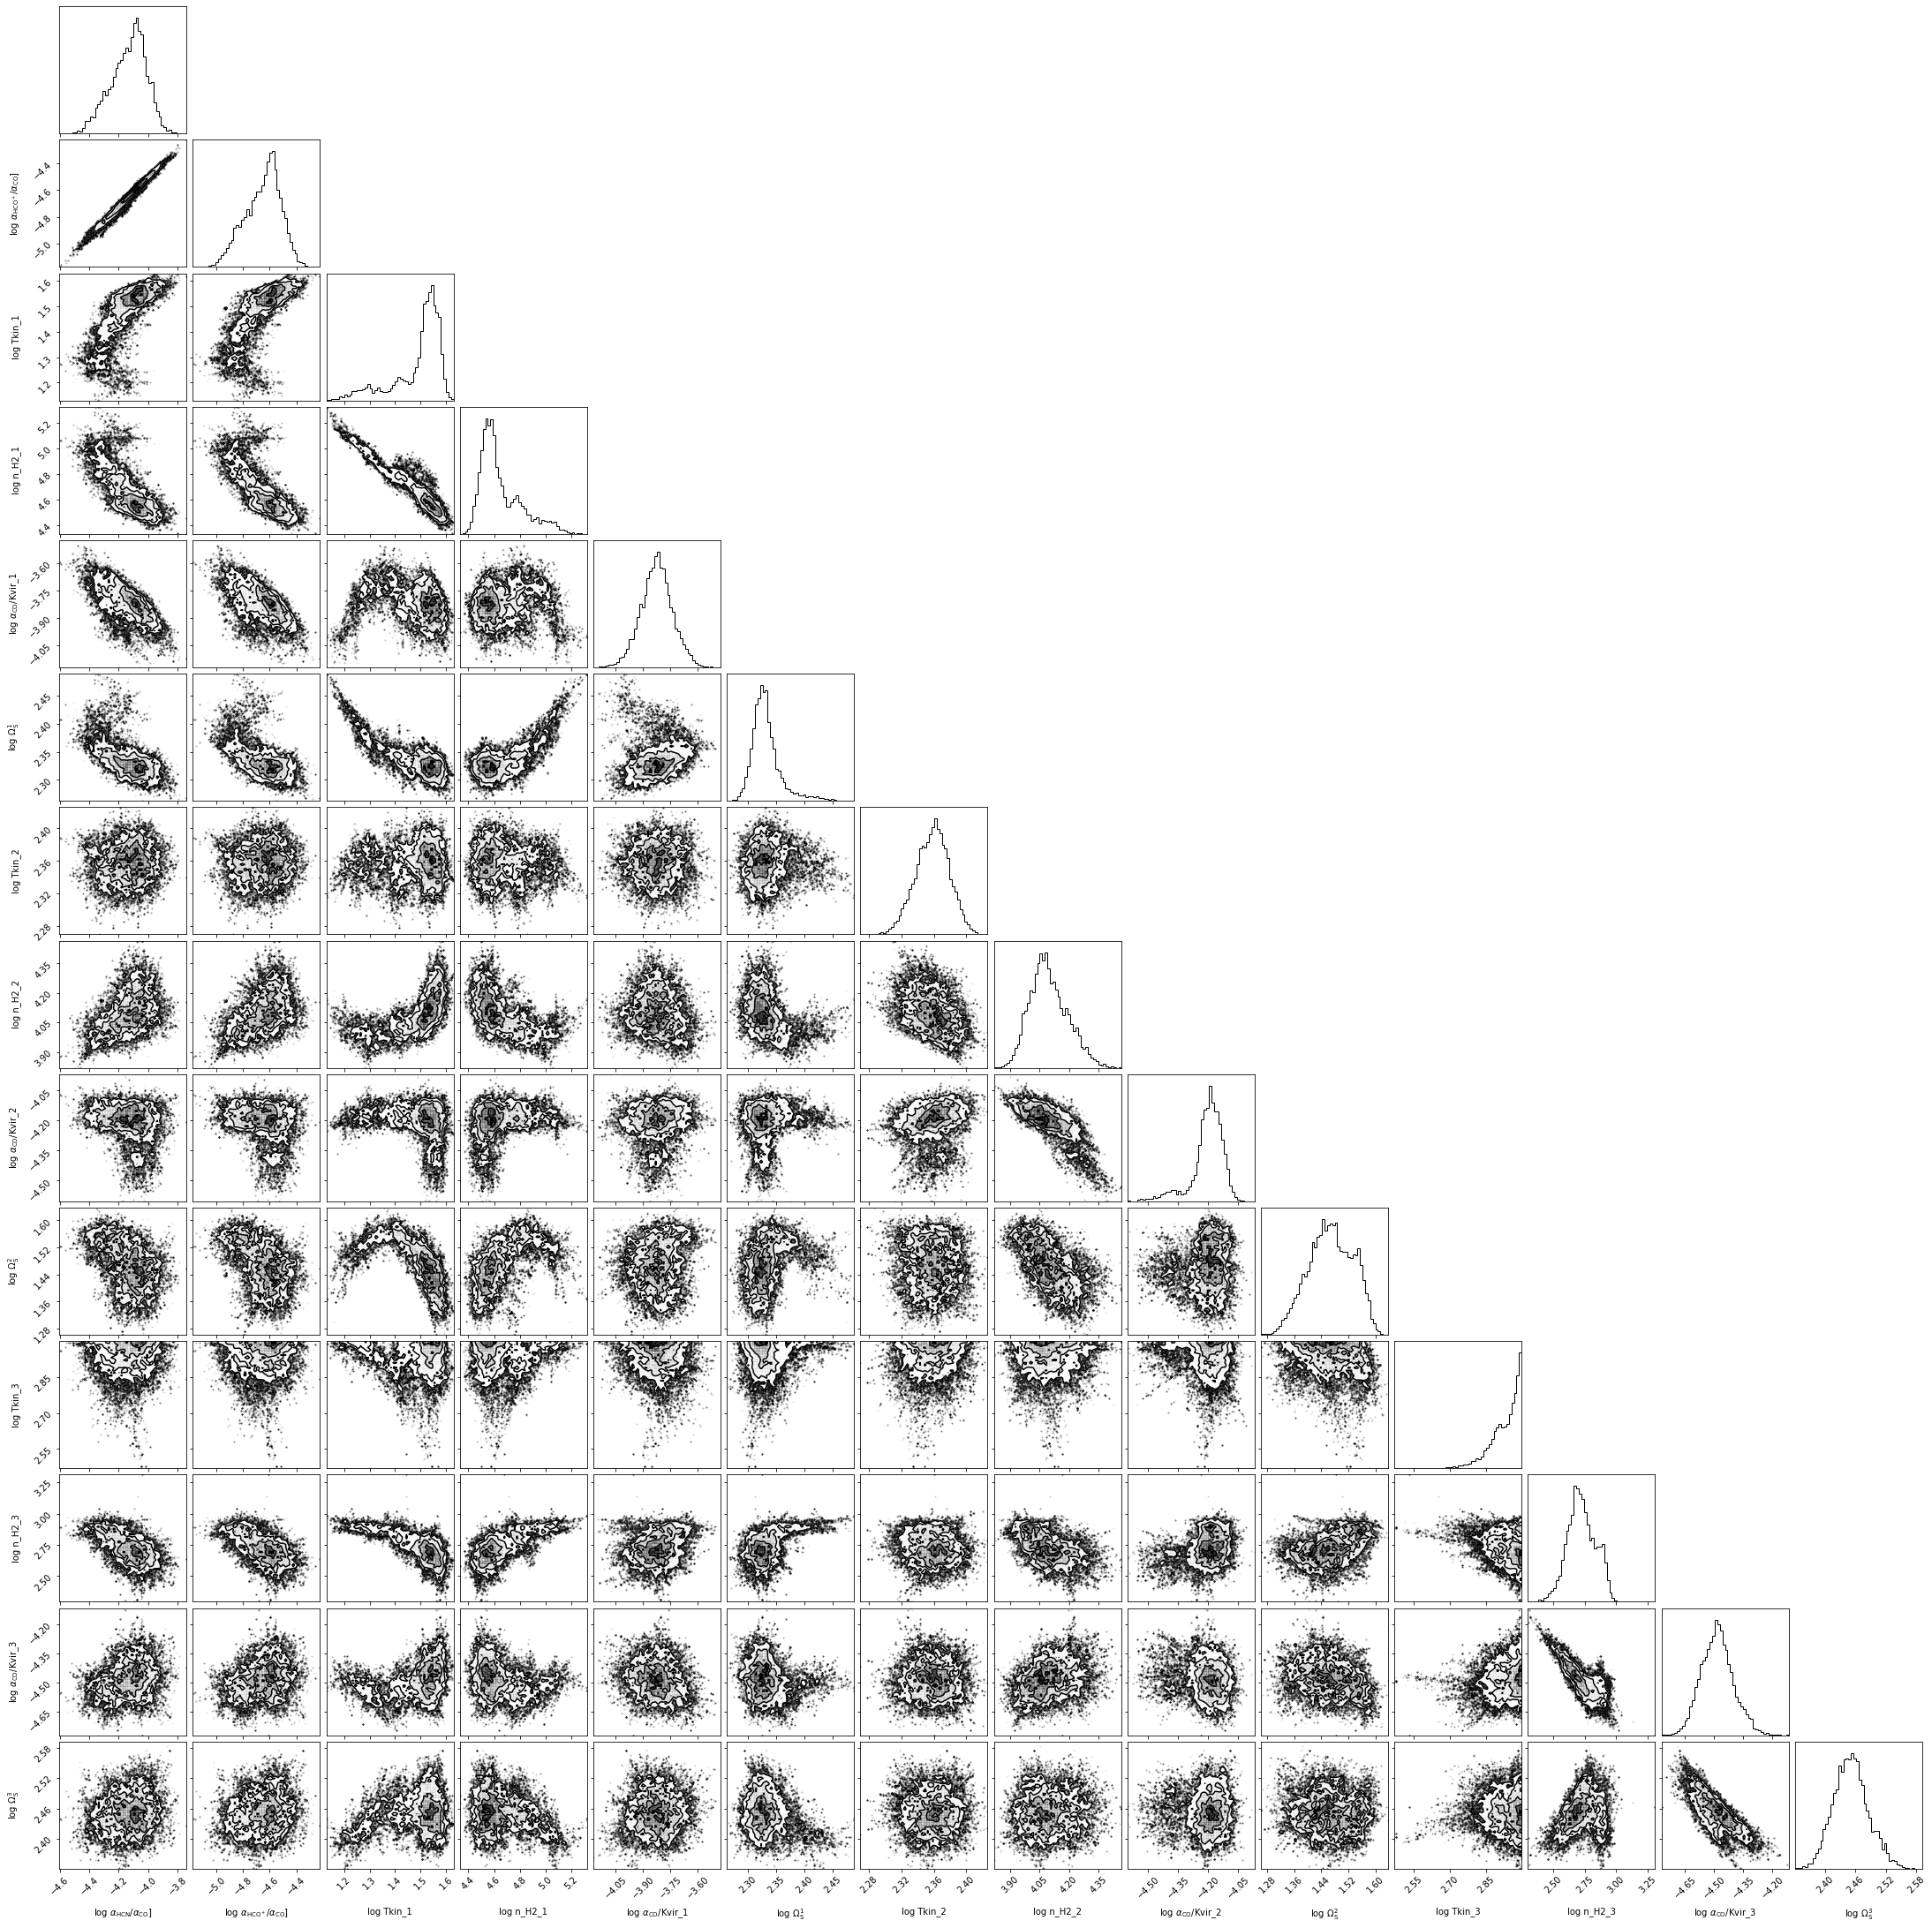

In [26]:
samples=sampler.get_chain(discard=6000)
log_prob_samples = sampler.get_log_prob(discard=6000)
max_index=np.where(log_prob_samples==np.max(log_prob_samples))
max_params=samples[max_index[0][0],max_index[1][0]]
print(samples.shape)
def best_fitting(samples):
    nparm=samples.shape[-1]
    result=np.zeros([nparm,3])
    for i in range(nparm):
        mcmc=np.percentile(samples[:,i],[16,50,84])
        q=np.diff(mcmc)
        result[i]=[mcmc[1],-q[0],q[1]]
    return result

import matplotlib.pyplot as plt
import corner
rng = [(x[0]+3*x[1], x[0]+3*x[2]) for x in pdf_params]
sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
sample_flag=sample_reshape
sample_flag=sample_reshape[sample_reshape[:,9]>1]
sample_flag=sample_flag[sample_flag[:,11]<4]
sample_flag=sample_flag[sample_flag[:,12]>-4.8]
pdf_params=best_fitting(sample_flag)
rng = [(x.min(),x.max()) for x in sample_flag.T]
fig=corner.corner(sample_flag, labels=[r"log $\alpha_{\rm HCN}/\alpha_{\rm CO}$]", r"log $\alpha_{\rm HCO^+}/\alpha_{\rm CO}$]",r"log Tkin_1",r"log n_H2_1",
                                      r"log $\alpha_{\rm CO}$/Kvir_1",r"log $\Omega^1_{\rm S}$",r"log Tkin_2",
                                      r"log n_H2_2",r"log $\alpha_{\rm CO}$/Kvir_2",r"log $\Omega^2_{\rm S}$",r"log Tkin_3",
                                      r"log n_H2_3",r"log $\alpha_{\rm CO}$/Kvir_3",r"log $\Omega^3_{\rm S}$"],range=rng,bins=50)
fig.savefig("three_component/corner.png")

[-4.12601802 -4.63557782  1.53117664  4.56343375 -3.79005564  2.32940449
  2.35682591  4.12411688 -4.22480123  1.46544776  2.98277654  2.58500124
 -4.38765287  2.42814001]


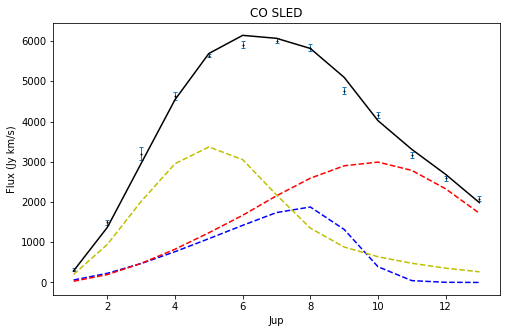

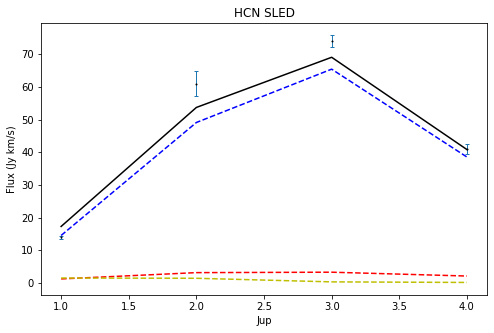

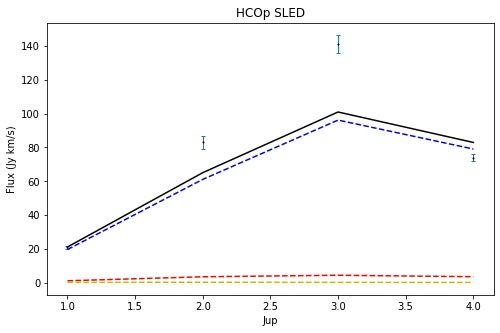

In [27]:
max_params_rc=max_params*1
print(max_params)
max_params_rc=max_params+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ab_hcn_co,ab_hco_co,Tkin_1,nH2_1,co_ab_Kvir_1,solidang_1,Tkin_2,nH2_2,co_ab_Kvir_2,solidang_2,\
        Tkin_3,nH2_3,co_ab_Kvir_3,solidang_3=10**pdf_params[:,0]

gas_comp1=gas_compnent(Tkin_1,nH2_1,co_ab_Kvir_1,co_ab_Kvir_1*ab_hcn_co,co_ab_Kvir_1*ab_hco_co,solidang_1)
gas_comp2=gas_compnent(Tkin_2,nH2_2,co_ab_Kvir_2,co_ab_Kvir_2*ab_hcn_co,co_ab_Kvir_2*ab_hco_co,solidang_2)
gas_comp3=gas_compnent(Tkin_3,nH2_3,co_ab_Kvir_3,co_ab_Kvir_3*ab_hcn_co,co_ab_Kvir_3*ab_hco_co,solidang_3)
model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
model_co_flux_2,model_hcn_flux_2,model_hco_flux_2=gas_comp2.compute_flux()
model_co_flux_3,model_hcn_flux_3,model_hco_flux_3=gas_comp3.compute_flux()
import matplotlib.pyplot as plt
def draw_SLED(flux,error,model1,model2,model3,Jup,name):
    fig=plt.figure(figsize=[8,5])
    plt.errorbar(Jup,flux,yerr=error,fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
    J_new=np.linspace(1,5,1000)
    plt.plot(Jup,model1[Jup-1],'b--')
    plt.plot(Jup,model2[Jup-1],'r--')
    plt.plot(Jup,model3[Jup-1],'y--')
    plt.plot(Jup,model1[Jup-1]+model2[Jup-1]+model3[Jup-1],'k-')
    plt.title('%s SLED'%(name))
    #plt.plot(J_new,smooth)
    plt.xlabel('Jup')
    #plt.yscale('log')
    plt.ylabel('Flux (Jy km/s)')
    plt.savefig('three_component/'+source_name+'_%s.pdf'%(name))
draw_SLED(co_flux,co_err,model_co_flux_1,model_co_flux_2,model_co_flux_3,co_Jup,'CO')
draw_SLED(hcn_flux,hcn_err,model_hcn_flux_1,model_hcn_flux_2,model_hcn_flux_3,hcn_Jup,'HCN')
draw_SLED(hco_flux,hco_err,model_hco_flux_1,model_hco_flux_2,model_hco_flux_3,hco_Jup,'HCOp')

In [28]:
10**0.35


2.2387211385683394